# EEG data examples

Here, we demonstrate `sbijax` using a complicated real world EEG data set.

In [1]:
import arviz as az
import jax
import numpy as np
import optax
import sbijax
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoLocator, MaxNLocator
from jax import numpy as jnp, random as jr
from jax._src.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax import distributions as tfd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import mne
import moabb

from jax.scipy.signal import welch
from moabb.datasets import Rodrigues2017

## EEG data

In [3]:
import tempfile
temp_dir = tempfile.TemporaryDirectory()

In [4]:
dataset = Rodrigues2017()
dataset.download(path=temp_dir.name, verbose=False)

In [5]:
raw = dataset._get_single_subject_data(subject=2)['0']['0']
raw = raw.filter(l_freq=3, h_freq=40, verbose=False)
raw = raw.resample(sfreq=128, verbose=False)

In [6]:
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=8.0, baseline=None, verbose=False)
epochs = epochs.load_data().pick_channels(['Oz'])

Using data from preloaded Raw for 10 events and 1025 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [7]:
X_closed = epochs['closed'].get_data().squeeze()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_closed_db = 10 * np.log10(S_closed)

X_opened = epochs['open'].get_data().squeeze()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_opened_db = 10 * np.log10(S_opened)

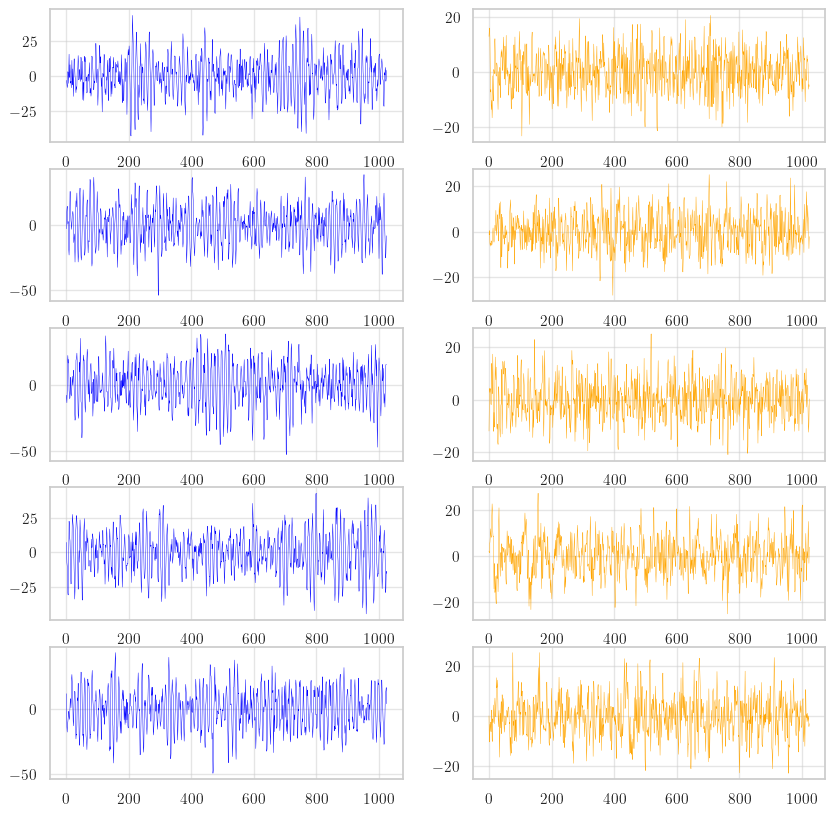

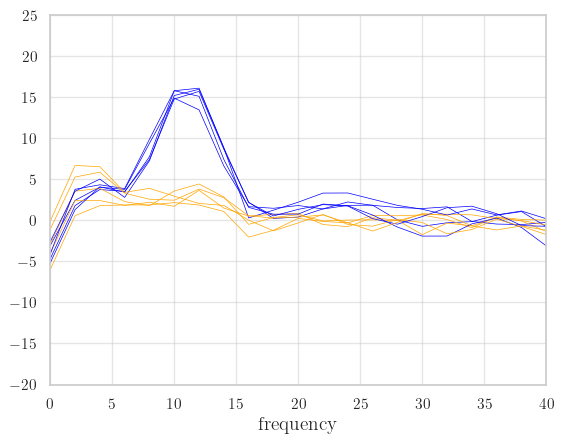

In [8]:
_, laxes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for i in range(5):
    laxes[i, 1].plot(X_opened[i, :], color="orange", label="opened", linewidth=.31)        
    laxes[i, 0].plot(X_closed[i, :], color="blue", label="closed", linewidth=.31)
#laxes[2, 1].plot(X_opened[i, :], color="orange", label="opened", linewidth=.31)        
#laxes[2, 0].plot(X_closed[i, :], color="blue", label="closed", linewidth=.31)
#laxes[5, 1].plot(X_opened_mean, color="darkorange", label="opened", linewidth=.31)    
#laxes[5, 0].plot(X_closed_mean, color="darkblue", label="closed", linewidth=.31)    
plt.show()

_, raxes = plt.subplots()
for i in range(5):
    raxes.plot(f, S_closed_db[i], color='blue', lw=.5)
    raxes.plot(f, S_opened_db[i], color='orange', lw=.5)
#raxes.plot(f, S_closed_db[2], color='blue', lw=.5)
#raxes.plot(f, S_opened_db[2], color='orange', lw=.5)
#raxes.plot(f, S_closed_db_mean, color='darkblue', lw=.5)
#raxes.plot(f, S_opened_db_mean, color='darkorange', lw=.5)
raxes.set_xlim(0, 40)
raxes.set_ylim(-20, +25)
raxes.set_xlabel('frequency', fontsize=14)
plt.show()

## Prior and simulator

In [9]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        C=tfd.Uniform(10.0, 250),
        mu=tfd.Uniform(50, 500),
        sigma=tfd.Uniform(50, 500),
        gain=tfd.Uniform(-20, 20),
    ), batch_ndims=0)
    return prior

prior = prior_fn()

In [10]:
def jansen_rit_fn(len_timeseries=1025, t_end=8.0):
    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr   
    sdbmp = importr("sdbmsABC")

    rset_seed = robjects.r["set.seed"]
    rchol = robjects.r["chol"]
    rt = robjects.r["t"]
    
    A = 3.25
    B = 22.0
    a = 10.0
    b = 50.0
    vmax = 5.0
    v0 = 6.0
    r = 0.56
    sigma4 = 0.01
    sigma6 = 1.0
    
    burnin = 2.0
    h = 1 / len_timeseries
    grid = robjects.FloatVector(list(np.arange(0, t_end + burnin, h)))    

    def fn(seed, theta):        
        rset_seed(int(np.sqrt(seed[0])))
        C, mu, sigma, gain = theta.tolist()
        gain_abs = 10 ** (gain / 10)
        y0 = robjects.FloatVector([0.08, 18, 15, -0.5, 0, 0])
        dm = sdbmp.exp_matJR(h, a, b)
        cm = rt(
            rchol(sdbmp.cov_matJR(h, robjects.FloatVector([0, 0, 0, sigma4, sigma, sigma6]), a, b))
        )
        yt = gain_abs * jnp.array(
            sdbmp.Splitting_JRNMM_output_Cpp(
                h, y0, grid, dm, cm, mu, C, A, B, a, b, v0, r, vmax
            )
        )
        yt = yt[int(burnin / h): ]
        yt = yt[::8]
        return yt

    return fn

simulate_jansen_rit = jansen_rit_fn()

In [13]:
import os

In [18]:
def simulator(seed, theta, len_timeseries=1025):    
    Cs, mus, sigmas, gains = theta["C"], theta["mu"], theta["sigma"], theta["gain"]
    seeds = jr.split(seed, Cs.shape[0])

    ys = np.zeros((Cs.shape[0], len_timeseries))
    
    for i, (C, mu, sigma, gain, seed) in enumerate(zip(Cs, mus, sigmas, gains, seeds)):        
        y = simulate_jansen_rit(seed, np.array([C, mu, sigma, gain]))
        ys[i] = np.array(y)
    return ys

In [19]:
def get_experimental_data():
    import os
    
    if os.path.exists("eeg_data.npz"):
        print("loading precomputed data")
        ret = np.load("eeg_data.npz", allow_pickle=True)
        return (
            ret["theta_synthetic"], 
            ret["y_synthetic"],
            ret["y_experimental_closed"],
            ret["y_experimental_opened"], 
            ret["theta_train"],
            ret["y_train"]
        )

    # synthetic data example
    theta_synthetic = np.array([135, 220, 2000, 0])
    y_synthetic = simulate_jansen_rit(jr.PRNGKey(1), theta_synthetic)
    y_synthetic = np.array(theta_synthetic)

    # experimental data
    y_experimental_closed = X_closed[[2]]
    y_experimental_opened = X_opened[[2]]    

    # simulations
    n = 100_000
    theta_train = prior.sample(seed=jr.PRNGKey(2), sample_shape=(n,))
    y_train = simulator(jr.PRNGKey(3), theta_train)
    np.savez_compressed(
        "eeg_data.npz", 
        theta_synthetic=theta_synthetic, 
        y_synthetic=y_synthetic, 
        y_experimental_closed=y_experimental_closed, 
        y_experimental_opened=y_experimental_opened,
        theta_train=theta_train, 
        y_train=y_train
   )
    
    return (
        theta_synthetic, 
        y_synthetic,
        y_experimental_closed,
        y_experimental_opened, 
        theta_train,
        y_train
    )

theta_synthetic, y_synthetic, y_experimental_closed, y_experimental_opened, theta_train, y_train = get_experimental_data()

loading precomputed data


In [21]:
y_train[100:110]

array([[7.84031311e+02, 7.78101929e+02, 7.71566162e+02, ...,
        7.46980408e+02, 7.50418823e+02, 7.53289246e+02],
       [2.16856426e+04, 2.16920117e+04, 2.16951289e+04, ...,
        2.16857168e+04, 2.16977383e+04, 2.17100527e+04],
       [1.40491382e+03, 1.41017236e+03, 1.41699451e+03, ...,
        1.39192676e+03, 1.39010120e+03, 1.38806213e+03],
       ...,
       [1.47224792e+02, 1.47071350e+02, 1.46861526e+02, ...,
        1.47039368e+02, 1.47358002e+02, 1.47460892e+02],
       [8.69833221e+01, 8.67746582e+01, 8.64274139e+01, ...,
        8.87529678e+01, 8.88007050e+01, 8.87218246e+01],
       [9.69443226e+00, 9.66687775e+00, 9.64643192e+00, ...,
        9.91746521e+00, 9.87773132e+00, 9.84573841e+00]])

# Summary statistics

In [ ]:
def summarize(y, n_summaries=33):
    _, summaries = welch(y, fs=epochs.info['sfreq'], nperseg=2 * (n_summaries - 1), axis=1)
    return summaries

In [201]:
f_train, summaries_train = summarize(y_train)

In [202]:
summaries_train.shape

(10, 33)

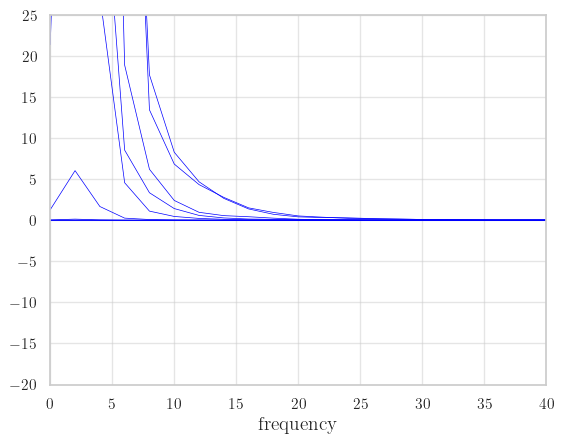

In [198]:
_, raxes = plt.subplots()
for i in range(10):
    raxes.plot(f, summaries_train[i], color='blue', lw=.5)
raxes.set_xlim(0, 40)
raxes.set_ylim(-20, +25)
raxes.set_xlabel('frequency', fontsize=14)
plt.show()

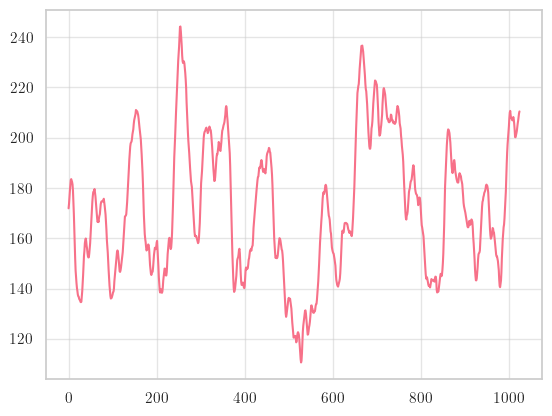

In [73]:
plt.plot(xxx)
plt.show()